In [3]:
# !pip install pandas
# !pip install numpy
# !pip install lightgbm
# !pip install seaborn
# !pip install matplotlib
# !pip install scikit-learn
# !pip install graphviz

In [4]:
import pandas as pd

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print(train_data.info()) # 6,995,055개의 데이터
print(test_data.info()) # 1,747,688개의 데이터

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995056 entries, 0 to 6995055
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   ID      object
 1   URL     object
 2   label   int64 
dtypes: int64(1), object(2)
memory usage: 160.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747689 entries, 0 to 1747688
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   ID      object
 1   URL     object
dtypes: object(2)
memory usage: 26.7+ MB
None


In [5]:
train_data.head()

,ID,URL,label
0,TRAIN_0000000,poznan[.]wuoz[.]gov[.]pl,0
1,TRAIN_0000001,vill[.]okawa[.]kochi[.]jp,0
2,TRAIN_0000002,nationalfinance[.]co[.]om,0
3,TRAIN_0000003,town[.]ozora[.]hokkaido[.]jp,0
4,TRAIN_0000004,open24[.]ie-news[.]irish/online/Login,1


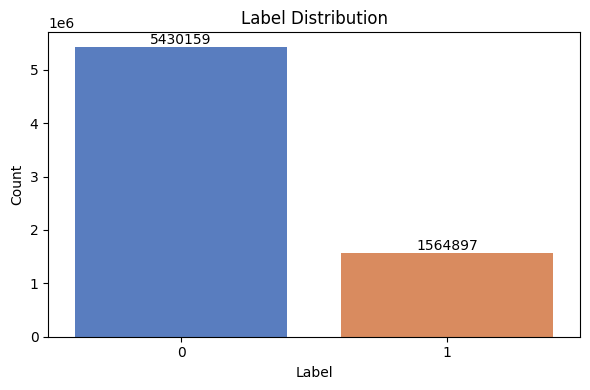

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  

ax = sns.countplot(
    x='label',
    hue='label',
    data=train_data,
    palette='muted',
    legend=False,  
)

plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,   # 막대 중앙 x 위치
        p.get_height() + 0.2,            # 막대 위쪽 y 위치
        f'{int(p.get_height())}',        # 개수 표시
        ha='center', va='bottom'
    )

plt.tight_layout()
plt.show()

In [7]:
train_data['URL'] = train_data['URL'].str.replace('[.]', '.')
test_data['URL'] = test_data['URL'].str.replace('[.]', '.')

In [8]:
import re
import string
import pandas as pd
import math 
from collections import Counter

# -----------------------------------
# URL normalize (핵심!)
# -----------------------------------

def normalize_url(url):
    if not re.match(r'^https?://', url):
        return 'http://' + url
    return url

# -----------------------------------
# Helper functions
# -----------------------------------

def count_digits(url):
    return sum(char.isdigit() for char in url)

def count_special_chars(url):
    return sum(char in string.punctuation for char in url)

def extract_domain(url):
    match = re.search(r'://([^/]+)', url)
    return match.group(1) if match else None

def has_digit(s):
    return any(c.isdigit() for c in str(s))

def count_unique_chars(url):
    return len(set(url))

def extract_tld(url):
    match = re.search(r'\.([a-zA-Z]{2,10})(?:/|$)', url)
    return match.group(1).lower() if match else None

def path_part(url):
    match = re.search(r'[^/]+/(.*)', url)
    return match.group(1) if match else ""

def query_part(url):
    match = re.search(r'\?(.*)', url)
    return match.group(1) if match else ""

def calculate_entropy(url):
    # 문자 빈도수 계산
    counter = Counter(url)
    length = len(url)
    
    # 섀넌 엔트로피 계산
    entropy = 0
    for count in counter.values():
        probability = count / length
        entropy -= probability * math.log2(probability)
    return entropy

def check_randomness(url):
    # 1. 엔트로피 계산
    entropy = calculate_entropy(url)
    
    # 2. 연속된 숫자나 문자의 최대 길이
    max_consecutive = 1
    current_consecutive = 1
    for i in range(1, len(url)):
        if url[i].isalnum() and url[i-1].isalnum() and url[i].lower() == url[i-1].lower():
            current_consecutive += 1
            max_consecutive = max(max_consecutive, current_consecutive)
        else:
            current_consecutive = 1
    
    # 3. 숫자와 문자의 교차 패턴 수
    transitions = 0
    for i in range(1, len(url)):
        if (url[i-1].isdigit() and url[i].isalpha()) or \
           (url[i-1].isalpha() and url[i].isdigit()):
            transitions += 1
    
    # 무작위성 점수 계산 (0~1 사이로 정규화)
    entropy_score = min(entropy / 5.0, 1.0)  # 일반적인 URL의 최대 엔트로피를 5로 가정
    consecutive_score = min(max_consecutive / 10.0, 1.0)  # 연속된 문자가 많을수록 낮은 점수
    transition_score = min(transitions / 10.0, 1.0)  # 전환이 많을수록 높은 점수
    
    # 종합 점수 계산 (가중치 조정 가능)
    randomness_score = (entropy_score * 0.5 + 
                       (1 - consecutive_score) * 0.3 + 
                       transition_score * 0.2)
    
    return randomness_score


# -----------------------------------
# Feature Engineering
# -----------------------------------

def add_url_features(df):
    df['URL_norm'] = df['URL'].apply(normalize_url)

    # 길이 기반
    df['length'] = df['URL'].str.len()
    df['subdomain_count'] = df['URL'].str.split('.').str.len()
    df['num_digits'] = df['URL'].apply(count_digits)
    df['num_special_chars'] = df['URL'].apply(count_special_chars)
    df['unique_chars'] = df['URL'].apply(count_unique_chars)

    # domain
    df['domain'] = df['URL_norm'].apply(extract_domain)
    df['domain_length'] = df['domain'].astype(str).str.len()
    df['domain_has_digit'] = df['domain'].apply(has_digit)
    df['num_hyphens'] = df['URL'].str.count('-')
    df['num_underscores'] = df['URL'].str.count('_')

    # IP URL
    df['is_ip_url'] = df['URL_norm'].str.contains(r'^\d{1,3}(\.\d{1,3}){3}')

    # http/https
    df['is_http'] = df['URL_norm'].str.startswith('http://')
    df['is_https'] = df['URL_norm'].str.startswith('https://')

    # :port
    df['has_port'] = df['URL_norm'].str.contains(r':\d{2,5}')

    # @
    df['has_at'] = df['URL_norm'].str.contains('@')

    # path & query
    df['path'] = df['URL_norm'].apply(path_part)
    df['path_length'] = df['path'].str.len()
    df['query'] = df['URL_norm'].apply(query_part)
    df['query_length'] = df['query'].str.len()
    df['num_params'] = df['query'].str.count('=')

    # tld
    df['tld'] = df['URL_norm'].apply(extract_tld)

    # 피싱 키워드
    phishing_keywords = ['login', 'secure', 'update', 'verify', 'account', 'bank',
                         'paypal', 'free', 'bonus', 'admin', 'redirect', 'auth',
                         'signin','server','click','immediate','confirm']
    df['has_phish_keyword'] = df['URL'].apply(
        lambda x: any(k in x.lower() for k in phishing_keywords)
    )
    #+URL 무작위성
    df['randomness'] = df['URL'].apply(check_randomness)

    return df


# -----------------------------------
# 실행
# -----------------------------------

train_data = add_url_features(train_data)
train_data.head()

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_23628\772069255.py:116: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['is_ip_url'] = df['URL_norm'].str.contains(r'^\d{1,3}(\.\d{1,3}){3}')


,ID,URL,label,URL_norm,length,subdomain_count,num_digits,num_special_chars,unique_chars,domain,...,has_port,has_at,path,path_length,query,query_length,num_params,tld,has_phish_keyword,randomness
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,http://poznan.wuoz.gov.pl,18,4,0,3,11,poznan.wuoz.gov.pl,...,False,False,/poznan.wuoz.gov.pl,19,,0,0,pl,False,0.600827
1,TRAIN_0000001,vill.okawa.kochi.jp,0,http://vill.okawa.kochi.jp,19,4,0,3,12,vill.okawa.kochi.jp,...,False,False,/vill.okawa.kochi.jp,20,,0,0,jp,False,0.587135
2,TRAIN_0000002,nationalfinance.co.om,0,http://nationalfinance.co.om,21,3,0,2,11,nationalfinance.co.om,...,False,False,/nationalfinance.co.om,22,,0,0,om,False,0.597280
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,http://town.ozora.hokkaido.jp,22,4,0,3,14,town.ozora.hokkaido.jp,...,False,False,/town.ozora.hokkaido.jp,23,,0,0,jp,False,0.593377
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,http://open24.ie-news.irish/online/Login,33,3,2,5,17,open24.ie-news.irish,...,False,False,/open24.ie-news.irish/online/Login,34,,0,0,irish,True,0.667245


C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_23628\3915600277.py:116: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['is_ip_url'] = df['URL_norm'].str.contains(r'^\d{1,3}(\.\d{1,3}){3}')


Validation Accuracy: 0.9263451635868741
Validation F1: 0.8193826576221276


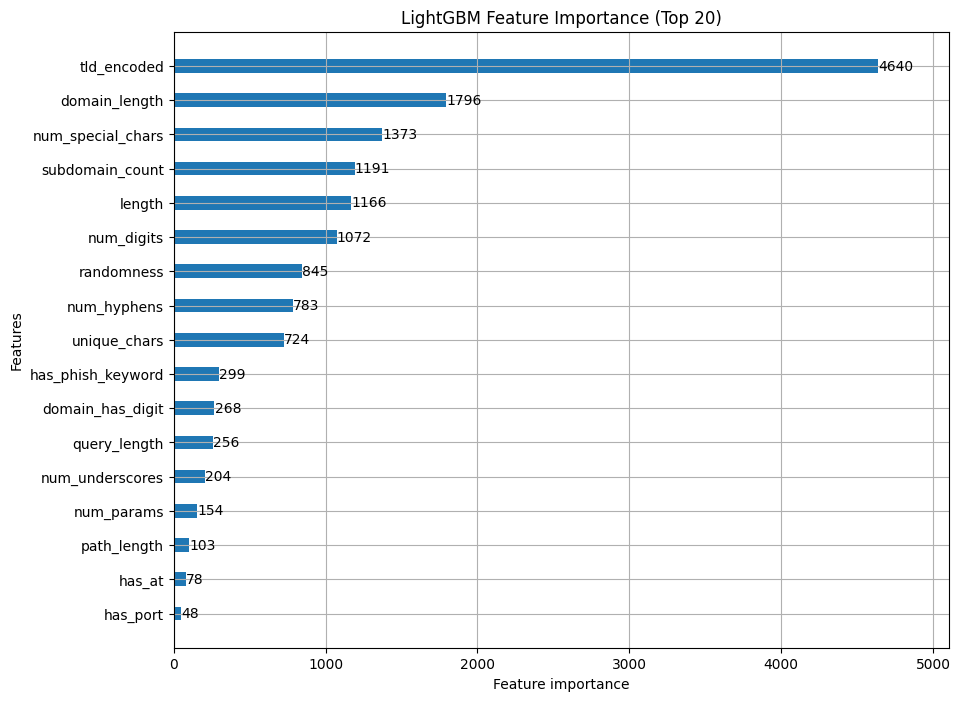

In [9]:
import re
import string
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import math
from collections import Counter

# =====================================================
# 1) URL normalize (스킴 없는 경우 http:// 자동 추가)
# =====================================================
def normalize_url(url):
    if not re.match(r'^https?://', url):
        return 'http://' + url
    return url

# =====================================================
# 2) Feature helper functions
# =====================================================
def count_digits(url):
    return sum(char.isdigit() for char in url)

def count_special_chars(url):
    return sum(char in string.punctuation for char in url)

def extract_domain(url):
    m = re.search(r'://([^/]+)', url)
    return m.group(1) if m else None

def extract_tld(url):
    m = re.search(r'\.([a-zA-Z]{2,10})(?:/|$)', url)
    return m.group(1).lower() if m else None

def count_unique_chars(url):
    return len(set(url))

def has_digit(s):
    return any(c.isdigit() for c in str(s))

def path_part(url):
    m = re.search(r'[^/]+/(.*)', url)
    return m.group(1) if m else ""

def query_part(url):
    m = re.search(r'\?(.*)', url)
    return m.group(1) if m else ""

def calculate_entropy(url):
    # 문자 빈도수 계산
    counter = Counter(url)
    length = len(url)
    
    # 섀넌 엔트로피 계산
    entropy = 0
    for count in counter.values():
        probability = count / length
        entropy -= probability * math.log2(probability)
    return entropy

def check_randomness(url):
    # 1. 엔트로피 계산
    entropy = calculate_entropy(url)
    
    # 2. 연속된 숫자나 문자의 최대 길이
    max_consecutive = 1
    current_consecutive = 1
    for i in range(1, len(url)):
        if url[i].isalnum() and url[i-1].isalnum() and url[i].lower() == url[i-1].lower():
            current_consecutive += 1
            max_consecutive = max(max_consecutive, current_consecutive)
        else:
            current_consecutive = 1
    
    # 3. 숫자와 문자의 교차 패턴 수
    transitions = 0
    for i in range(1, len(url)):
        if (url[i-1].isdigit() and url[i].isalpha()) or \
           (url[i-1].isalpha() and url[i].isdigit()):
            transitions += 1
    
    # 무작위성 점수 계산 (0~1 사이로 정규화)
    entropy_score = min(entropy / 5.0, 1.0)  # 일반적인 URL의 최대 엔트로피를 5로 가정
    consecutive_score = min(max_consecutive / 10.0, 1.0)  # 연속된 문자가 많을수록 낮은 점수
    transition_score = min(transitions / 10.0, 1.0)  # 전환이 많을수록 높은 점수
    
    # 종합 점수 계산 (가중치 조정 가능)
    randomness_score = (entropy_score * 0.5 + 
                       (1 - consecutive_score) * 0.3 + 
                       transition_score * 0.2)
    
    return randomness_score

# =====================================================
# 3) Feature Engineering
# =====================================================
def add_url_features(df):
    df['URL_norm'] = df['URL'].apply(normalize_url)

    df['length'] = df['URL'].str.len()
    df['subdomain_count'] = df['URL'].str.split('.').str.len()
    df['num_digits'] = df['URL'].apply(count_digits)
    df['num_special_chars'] = df['URL'].apply(count_special_chars)
    df['unique_chars'] = df['URL'].apply(count_unique_chars)

    df['domain'] = df['URL_norm'].apply(extract_domain)
    df['domain_length'] = df['domain'].astype(str).str.len()
    df['domain_has_digit'] = df['domain'].apply(has_digit)

    df['num_hyphens'] = df['URL'].str.count('-')
    df['num_underscores'] = df['URL'].str.count('_')

    df['is_ip_url'] = df['URL_norm'].str.contains(r'^\d{1,3}(\.\d{1,3}){3}')
    df['is_http'] = df['URL_norm'].str.startswith('http://')
    df['is_https'] = df['URL_norm'].str.startswith('https://')
    df['has_port'] = df['URL_norm'].str.contains(r':\d{2,5}')
    df['has_at'] = df['URL_norm'].str.contains('@')

    df['path'] = df['URL_norm'].apply(path_part)
    df['path_length'] = df['path'].str.len()
    df['query'] = df['URL_norm'].apply(query_part)
    df['query_length'] = df['query'].str.len()
    df['num_params'] = df['query'].str.count('=')

    df['tld'] = df['URL_norm'].apply(extract_tld)
    
    # ✅ phish keyword feature 추가 (train과 test 일치!)
    phishing_keywords = ['login', 'secure', 'update', 'verify', 'account', 'bank',
                         'paypal', 'free', 'bonus', 'admin', 'redirect', 'auth',
                         'signin','server','click','immediate','confirm']
    df['has_phish_keyword'] = df['URL'].apply(
        lambda x: any(k in x.lower() for k in phishing_keywords)
    )
     #+URL 무작위성
    df['randomness'] = df['URL'].apply(check_randomness)

    return df


# =====================================================
# 4) Feature Engineering 실행
# =====================================================
df = add_url_features(train_data.copy())

# tld 인코딩 (문자열은 LightGBM이 못 먹음)
le = LabelEncoder()
df['tld_encoded'] = le.fit_transform(df['tld'].astype(str))


# =====================================================
# 5) Feature 선택 (문자열 제거)
# =====================================================
exclude_cols = [
    'ID',        # 필요 없음
    'URL',
    'URL_norm',
    'domain',
    'path',
    'query',
    'tld',
    'label'
]

features = [c for c in df.columns if c not in exclude_cols]

X = df[features]
y = df['label']


# =====================================================
# 6) Train / Valid split
# =====================================================
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_dataset = lgb.Dataset(X_train, label=y_train)
valid_dataset = lgb.Dataset(X_valid, label=y_valid)


# =====================================================
# 7) LightGBM Baseline 모델
# =====================================================
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

model = lgb.train(
    params,
    train_dataset,
    valid_sets=[valid_dataset],
    valid_names=['valid'],
    num_boost_round=500  
)
feature_list = features.copy()

# =====================================================
# 8) 평가
# =====================================================
valid_pred = model.predict(X_valid)
valid_pred_label = (valid_pred > 0.5).astype(int)

acc = accuracy_score(y_valid, valid_pred_label)
f1 = f1_score(y_valid, valid_pred_label)

print("Validation Accuracy:", acc)
print("Validation F1:", f1)

# Feature Importance
lgb.plot_importance(model, max_num_features=20, height=0.4, figsize=(10, 8))
plt.title("LightGBM Feature Importance (Top 20)")
plt.show()

ImportError: You must install graphviz and restart your session to plot tree.

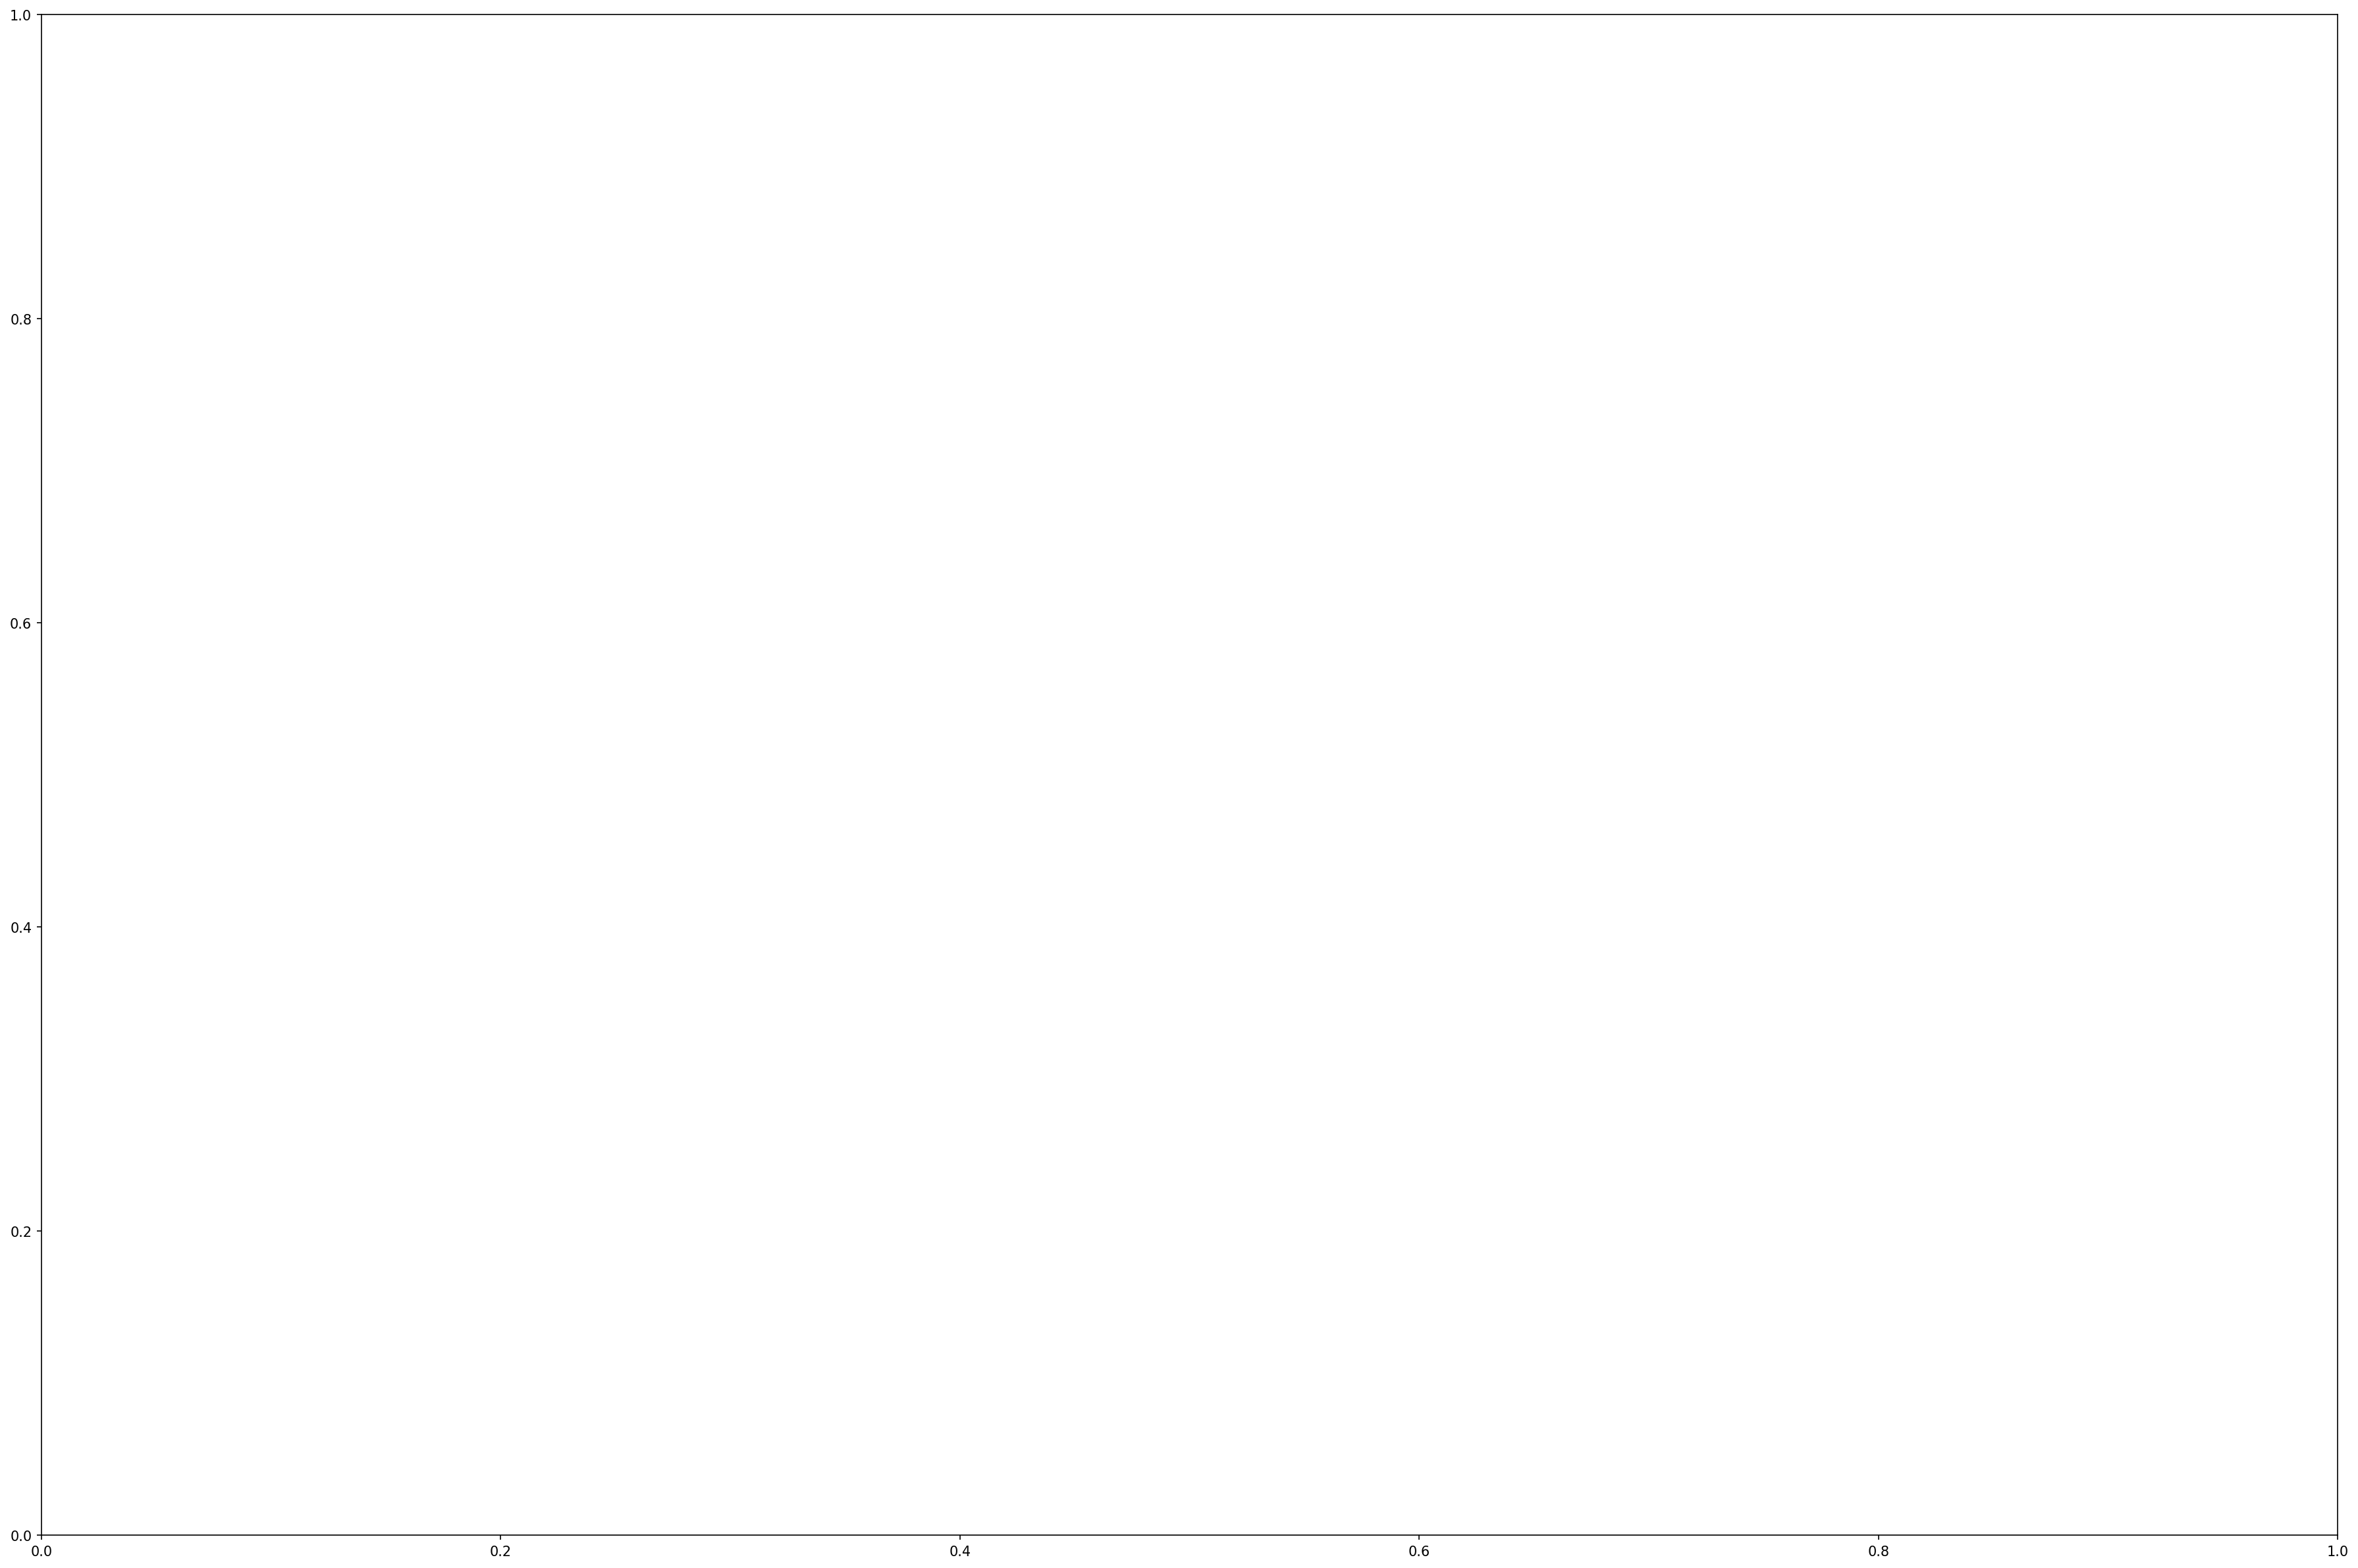

In [10]:
lgb.plot_tree(model, tree_index=0, figsize=(30, 20), dpi=150)
plt.show()

In [11]:
# ------------------------------
# 1) test feature engineering
# ------------------------------
test_df = add_url_features(test_data.copy())

# ------------------------------
# 2) TLD 처리 (unseen → unknown)
# ------------------------------
test_df['tld_fixed'] = test_df['tld'].astype(str).apply(
    lambda x: x if x in le.classes_ else "unknown"
)

# unknown 추가 후 re-fit
new_classes = list(le.classes_)
if "unknown" not in new_classes:
    new_classes.append("unknown")
le.fit(new_classes)

test_df['tld_encoded'] = le.transform(test_df['tld_fixed'])

# ------------------------------
# 3) feature 리스트는 train에서 그대로 불러옴
# ------------------------------

X_test = test_df[feature_list]

# ------------------------------
# 4) predict
# ------------------------------
test_pred = model.predict(X_test)

# ------------------------------
# 5) submission 생성
# ------------------------------
submission = pd.DataFrame({               
    'ID': test_df['ID'],
    'probability': (test_pred > 0.5).astype(int)   # ✅ 0/1로 변환
})

submission.to_csv("submission.csv", index=False)
submission.head()

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_23628\3915600277.py:116: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['is_ip_url'] = df['URL_norm'].str.contains(r'^\d{1,3}(\.\d{1,3}){3}')


,ID,probability
0,TEST_0000000,0
1,TEST_0000001,0
2,TEST_0000002,0
3,TEST_0000003,0
4,TEST_0000004,0
